In Step-3, we trained multiple models and tested their performance with various configuration using Cross-validation.

In this step, we'll:
* Tune the hyperparameters for top-2 models selected from the previous step i.e. Logistic regression & Xgboost to squeeze any metric improvement if possible. We'll either use `GridSearchCV` or `RandomSearchCV` for hyperparameter-tuning.
* Choose an optimal threshold value that maximizes the model predictions (labels) such as F1-score & PR-AUC
* Combine both the model's prediction using ensemble technique (Voting Classifier)

In [1]:
# Add src path
import sys
sys.path.append("../")

In [2]:
# Imports 
from src.utils import TRAIN_DATA_PATH, TEST_DATA_PATH
from src.data_preprocessing.preprocessor import build_pipeline

import os
import mlflow
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

In [3]:
# Load the data
train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_status
0,18500.0,60 months,10.65,340.24,B,B2,CNMI Government,10+ years,OWN,40000.0,...,0.0,8.0,0.1,27.0,f,INDIVIDUAL,NaN,0.0,"7530 Barnes Flat Apt. 584\r\nWhitetown, NV 30723",Fully Paid
1,13175.0,36 months,16.55,466.78,D,D2,customer service / account rep,4 years,RENT,30000.0,...,1.0,1046.0,15.8,8.0,f,INDIVIDUAL,0.0,0.0,"443 Rice Views Apt. 282\r\nNorth Jameshaven, A...",Fully Paid
2,35000.0,60 months,17.86,886.11,D,D5,Branch Manager,10+ years,MORTGAGE,80000.0,...,0.0,20239.0,57.5,36.0,w,INDIVIDUAL,2.0,0.0,3857 Christopher Courts Suite 005\r\nEast Chri...,Charged Off
3,20400.0,36 months,12.12,678.75,B,B3,California Dept of transportation,10+ years,RENT,65000.0,...,0.0,12717.0,49.4,31.0,f,INDIVIDUAL,0.0,0.0,"840 Parks Viaduct\r\nLake Brittanyside, MT 48052",Fully Paid
4,35000.0,60 months,17.57,880.61,D,D4,Air Traffic Control Specialist,10+ years,RENT,200000.0,...,0.0,14572.0,63.1,8.0,w,INDIVIDUAL,0.0,0.0,"042 Jamie Grove\r\nEast Maryshire, LA 70466",Charged Off


In [4]:
# Create dataframe copy to work on
train_df_copy = train_df.copy()

# Feature types
target_feat = "loan_status"
independent_feat = [col for col in train_df_copy.columns if col!=target_feat and col not in {"title", "emp_title"}] # excluding title & emp_title columns from beginning
date_feat = ["issue_d", "earliest_cr_line"]
num_feat = [col for col in independent_feat if train_df_copy[col].dtype=="float"]
cat_feat = [col for col in independent_feat if col not in set(num_feat).union(date_feat)]
eng_feat = ["emi_ratio", "credit_age_years", "closed_acc", "credit_util_ratio", "mortgage_ratio"]

# Types of categorical features
ordinal_feat = ["grade", "sub_grade", "emp_length"]
supervised_feat = ["purpose", "address"] # features to receive supervised categorical encoding i.e. Target encoding
ohe_feat = ["verification_status", "application_type", "initial_list_status", "home_ownership"]

In [5]:
# Fetch X & y
X, y = train_df_copy[independent_feat], train_df_copy[target_feat]

# Encoding the target feature
y = y.map({"Charged Off": 1, "Fully Paid": 0})

In [7]:
# Set mlflow tracking uri & experiment
tracking_uri_path = os.path.abspath("../mlflow_tracking/mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{tracking_uri_path}")
mlflow.set_experiment("loantap-experiments")

<Experiment: artifact_location='file:///c:/Users/raon1/Desktop/Python/Projects/LoanTap/mlflow_tracking/mlruns/529194635109779319', creation_time=1765452200241, experiment_id='529194635109779319', last_update_time=1765452200241, lifecycle_stage='active', name='loantap-experiments', tags={'mlflow.experimentKind': 'custom_model_development'}>

# Hyperparameter Tuning

## Logistic regression

From Step-3, we know that the following configuration provided the best results for validation set with Logistic regression:
* Ignoring dropping features based on VIF analysis
* Dropping Missing values
* Onehot encoding for all categorical features (except ordinal features)
* Keep outliers as is
* Use class weights to handle class imbalance

We'll first preprocess the data as per above configurations, then with defined set of hyperparameters and their possible values, find the optimal parameter combinations.

In [28]:
# Dropping missing values before preprocessing
nan_rows = X.isna().any(axis=1)
X, y = X.loc[~nan_rows], y.loc[~nan_rows]

# Getting the preprocessed data
supervised_feat = None
ohe_feat = ["verification_status", "application_type", "initial_list_status", "home_ownership", "purpose", "address"]
feat_to_drop = date_feat + ["grade", "total_acc"]

preprocessing_pipe = build_pipeline(
    numerical_features=num_feat,
    engineered_features=eng_feat,
    categorical_features=cat_feat,
    supervised_features=supervised_feat,
    onehot_features=ohe_feat,
    ordinal_features=ordinal_feat,
    use_imputation=False,
    use_outlier_capping=False,
    use_encoding=True,
    use_scaling=True,
    use_smote=False,
    features_to_drop=feat_to_drop,
    convert_cat_dtype=False
)
X_logreg = preprocessing_pipe.fit_transform(X, y)
X_logreg.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,dti,open_acc,pub_rec,...,purpose_wedding,address_05113,address_11650,address_22690,address_29597,address_30723,address_48052,address_70466,address_86630,address_93700
1,0.056250,0,0.506515,0.240910,0.666667,-0.285714,-0.813953,-1.268872,-0.833333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.875000,1,0.719870,1.541884,1.000000,0.571429,0.348837,1.455471,0.166667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.658333,0,-0.214984,0.898548,-0.333333,0.571429,0.000000,0.346056,1.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.875000,1,0.672638,1.524820,0.888889,0.571429,3.139535,-1.029686,-1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.125000,0,-1.322476,0.100769,-1.111111,0.285714,0.000000,-0.530110,-0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
# Tune hyperparameters & log
# Model instantiation
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="saga" # only solver supporting elastic-net
)

# Parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.5, 1]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring=["f1", "average_precision"],
    cv=cv,
    refit="f1",
    return_train_score=True,
    n_jobs=-1
)

with mlflow.start_run(run_name="Logreg_Gridsearch"):
    grid_search.fit(X_logreg, y)

    # Search results
    results_df = pd.DataFrame(grid_search.cv_results_)
    mlflow.log_table(results_df, "grid_search_results.json")

    # Log each search combination metrics for visualization
    for idx in range(len(results_df)):
        mlflow.log_param(f"params_{idx}", results_df.loc[idx, "params"])
        mlflow.log_metrics({
            "mean_test_f1": results_df.loc[idx, "mean_test_f1"],
            "mean_test_avg_precision": results_df.loc[idx, "mean_test_average_precision"]
        })

    # Log the best params, metrics & model
    best_index = grid_search.best_index_
    best_params = grid_search.best_params_
    
    for k, v in best_params.items():
        mlflow.log_param(f"best_{k}", v)

    mlflow.log_metric("best_f1", results_df.loc[best_index, "mean_test_f1"])
    mlflow.log_metric("best_avg_precision", results_df.loc[best_index, "mean_test_average_precision"])

    mlflow.sklearn.log_model(
        sk_model=grid_search.best_estimator_,
        name="log_reg_best_model",
        input_example=X_logreg.head()
    )

c:\Users\raon1\Desktop\Python\Projects\LoanTap\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\raon1\Desktop\Python\Projects\LoanTap\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.war

### Insights

The best parameters for Logistic regression:
* C = 0.01 (i.e. regularization parameter $\lambda$=100)
* l1_ratio = 0 (i.e. only L2 regularization)

The best metric values:
* F1 = 0.63
* PR-AUC (Average Precision) = 0.782

## Xgboost

From Step-3, we know that the following configuration provided the best results for validation set with Xgboost:
* Dropping Missing values
* Target encoding for all categorical features (except ordinal features)
* Cap the outliers
* Scale up the positive class samples to handle class-imbalance

We'll first preprocess the data as per above configurations, then with defined set of hyperparameters and their possible values, find the optimal parameter combinations. 

Also, since the possible number of combinations is very high, we'll use RandomizedSearchCV instead to find the optimal set of parameters.

In [56]:
# Resetting the X & y back to original data
X, y = train_df_copy[independent_feat], train_df_copy[target_feat]

# Encoding the target feature
y = y.map({"Charged Off": 1, "Fully Paid": 0})

In [57]:
# Dropping missing values before preprocessing
nan_rows = X.isna().any(axis=1)
X, y = X.loc[~nan_rows], y.loc[~nan_rows]

# Getting the preprocessed data
supervised_feat = ["verification_status", "application_type", "initial_list_status", "home_ownership", "purpose", "address"]
ohe_feat = None
feat_to_drop = date_feat

preprocessing_pipe = build_pipeline(
    numerical_features=num_feat,
    engineered_features=eng_feat,
    categorical_features=cat_feat,
    supervised_features=supervised_feat,
    onehot_features=ohe_feat,
    ordinal_features=ordinal_feat,
    use_imputation=False,
    use_outlier_capping=True,
    use_encoding=True,
    use_scaling=False,
    use_smote=False,
    features_to_drop=feat_to_drop,
    convert_cat_dtype=False
)
X_xgb = preprocessing_pipe.fit_transform(X, y)
X_xgb.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,address,emi_ratio,credit_age_years,closed_acc,negative_rec,credit_util_ratio,mortgage_ratio
1,13175.0,0,16.55,466.78,3,16,4,0.230925,30000.0,0.220095,...,0.197565,0.0,0.0,0.000000,0.19,25.0,2.0,1,0.03,0.00
2,35000.0,1,17.86,886.11,3,19,10,0.170248,80000.0,0.220095,...,0.197565,2.0,0.0,0.194066,0.13,17.0,24.0,0,0.25,0.06
3,20400.0,0,12.12,678.75,1,7,10,0.230925,65000.0,0.220095,...,0.197565,0.0,0.0,0.201180,0.13,14.5,13.0,0,0.20,0.00
4,35000.0,1,17.57,880.61,3,18,10,0.230925,200000.0,0.220095,...,0.197565,0.0,0.0,0.196786,0.05,6.2,3.0,0,0.07,0.00
5,14000.0,0,5.32,421.61,0,0,8,0.204135,65000.0,0.149067,...,0.197565,2.0,0.0,0.197250,0.08,11.1,17.0,0,0.02,0.07


In [59]:
# Tune hyperparameters & log
neg_pos_sample_ratio = (y==0).sum() / (y==1).sum()

# Model instantiation
xgb_model = XGBClassifier(
    scale_pos_weight=neg_pos_sample_ratio,
    random_state=42,
    n_jobs=-1
)

# Parameter distributions to sample from
param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsubsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 10), 
    "reg_lambda": [1, 2, 5, 10]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring=["f1", "average_precision"],
    cv=cv,
    refit="f1",
    n_iter=50,
    return_train_score=True,
    n_jobs=-1
)

with mlflow.start_run(run_name="Xgboost_Randomizedsearch"):
    random_search.fit(X_xgb, y)

    # Search results
    results_df = pd.DataFrame(random_search.cv_results_)
    mlflow.log_table(results_df, "random_search_results.json")

    # Log each search combination metrics for visualization
    for idx in range(len(results_df)):
        mlflow.log_param(f"params_{idx}", results_df.loc[idx, "params"])
        mlflow.log_metrics({
            "mean_test_f1": results_df.loc[idx, "mean_test_f1"],
            "mean_test_avg_precision": results_df.loc[idx, "mean_test_average_precision"]
        })

    # Log the best params, metrics & model
    best_index = random_search.best_index_
    best_params = random_search.best_params_
    
    for k, v in best_params.items():
        mlflow.log_param(f"best_{k}", v)

    mlflow.log_metric("best_f1", results_df.loc[best_index, "mean_test_f1"])
    mlflow.log_metric("best_avg_precision", results_df.loc[best_index, "mean_test_average_precision"])

    mlflow.sklearn.log_model(
        sk_model=random_search.best_estimator_,
        name="xgboost_best_model",
        input_example=X_xgb.head()
    )

c:\Users\raon1\Desktop\Python\Projects\LoanTap\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:10:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsubsample_bytree" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\raon1\Desktop\Python\Projects\LoanTap\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handli

### Insights

The best parameters for Xgboost:
* n_estimators = 281
* max_depth = 7
* learning_rate = 0.144
* subsample = 0.967
* colsubsample_bytree = 0.938
* min_child_weight = 5
* reg_lambda = 1

The best metric values:
* F1 = 0.637
* PR-AUC (Average Precision) = 0.783

# Feature importances

We'll look at the feature importance values for both the models, to get an idea of which features are more influential & crucial while predictions

In [ ]:
# Load the best models using their logged model-id (see Mlflow-UI)
logreg_model = mlflow.sklearn.load_model("models:/m-edeac060c27846169e1b656959faa9f6")
xgb_model = mlflow.sklearn.load_model("models:/m-63b13cba478145f998dcb4b55bf22153")

In [ ]:
# Log-reg model coefficients 
logreg_feat_importances = pd.DataFrame(data=logreg_model.coef_.ravel(), 
                                       index=logreg_model.feature_names_in_, 
                                       columns=["feature_importances"]) \
                                       .sort_values("feature_importances", ascending=False)
logreg_feat_importances

,feature_importances
address_11650,5.534966
address_93700,5.533299
address_86630,5.517040
address_48052,2.046264
address_70466,2.016179
address_30723,2.010256
address_22690,2.001009
sub_grade,1.212792
term,0.395465
emi_ratio,0.291264


In [74]:
# Xgboost model feature importances
xgb_feat_importances = pd.DataFrame(data=xgb_model.feature_importances_, 
                                    index=xgb_model.feature_names_in_, 
                                    columns=["feature_importances"])\
                                    .sort_values("feature_importances", ascending=False)
xgb_feat_importances

,feature_importances
address,0.747248
sub_grade,0.056743
grade,0.049615
term,0.023839
home_ownership,0.009024
emi_ratio,0.007931
dti,0.006463
application_type,0.006354
mort_acc,0.006086
int_rate,0.005501


## Insights

* `address` (pincode categories for Logistic regression) is the most influential feature for both the models. So, geography of the applicant matters a lot.
* `sub_grade` is the next important feature after address. This makes sense as this feature represents the riskiness of the loan assigned by the lender themself. A1 subgrade is the safest while G5 is the riskiest
* `term`, `emi_ratio` & `dti` are also the common in top most important features for both the models. Longer loan term might have higher default rate, while higher emi_ratio & dti will pretty obviously have higher likeliness of defaulting

# Threshold optimization

The default probability threshold used by __LogisticRegression & XGBClassifier__ is 0.5. But since our dataset is imbalanced, we might need to carefully choose the threshold to reduce misclassifications and maximize the metrics such as Precision, Recall.

We'll use Precision-Recall curve to visualize the metrics & choose the threshold providing the best tradeoff between Precision & Recall, hence the best F1 score

In [97]:
def pick_best_threshold(model, X, y, run_name):
    with mlflow.start_run(run_name=run_name):
        # Fetch the model predictions via Cross-validation
        # This ensures unbiased probabilities of the model on unseen data, rather than using refitted model on entire training set
        y_probs = cross_val_predict(
            estimator=model,
            X=X, 
            y=y,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            method="predict_proba",
            n_jobs=-1
        )[:, 1] # probability predictions for only class=1

        # Precision & Recall for all the threshold/y_probs
        precisions, recalls, thresholds = precision_recall_curve(
            y_true=y,
            y_score=y_probs
        )
        f1 = (2 * precisions * recalls) / (precisions + recalls)

        # Finding the threshold for the best f1
        best_index = np.argmax(f1)
        best_threshold = thresholds[best_index]
        best_f1, best_precision, best_recall = f1[best_index], precisions[best_index], recalls[best_index]

        # Print the best metrics values
        print(f"Best threshold: {best_threshold}")
        print(f"Best F1: {best_f1}")
        print(f"Best Precision: {best_precision}, Best Recall: {best_recall}")

        # Log the metrics, threshold & visualization
        mlflow.log_param("best_threshold", best_threshold)
        mlflow.log_metrics(
            {
                "best_f1": best_f1,
                "best_precision": best_precision,
                "best_recall": best_recall
            }
        )
        pr_curve = PrecisionRecallDisplay.from_predictions(
            y_true=y, 
            y_pred=y_probs,
            plot_chance_level=True
        )
        mlflow.log_figure(pr_curve.figure_, f"{run_name.split("_")[0]}_PR_curve.png")

        return best_threshold

## Logistic regression

Best threshold: 0.6515210551360162
Best F1: 0.6602197802197802
Best Precision: 0.7149904794876233, Best Recall: 0.6132432633063618


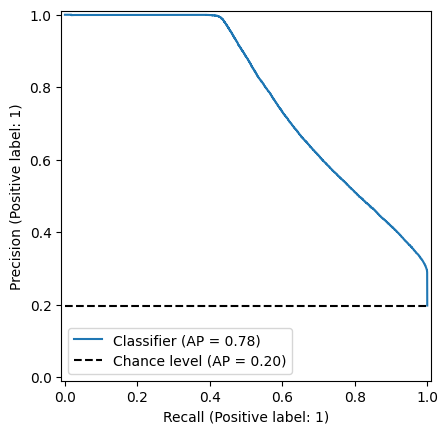

In [99]:
# Finding best threshold for Logistic Regression
lr_best_params = {
    "C": 0.01,
    "l1_ratio": 0
}
lr_model = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    **lr_best_params
)

lr_best_threshold = pick_best_threshold(lr_model, X=X_logreg, y=y, run_name="Logreg_threshold_search")

## Xgboost

Best threshold: 0.6432831883430481
Best F1: 0.6614416085110536
Best Precision: 0.6976179201581191, Best Recall: 0.6288323064360478


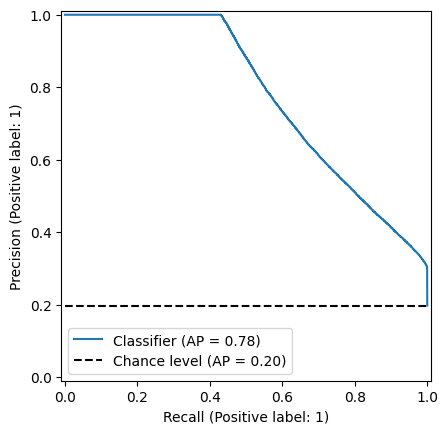

In [100]:
# Finding best threshold for Xgboost
# Rounding the parameters values to 3 decimal places
xgb_best_params = {
    "n_estimators": 281,
    "max_depth": 7,
    "learning_rate": 0.144,
    "subsample": 0.966,
    "colsubsample_bytree": 0.938,
    "min_child_weight": 5,
    "reg_lambda": 1
}
xgb_model = XGBClassifier(
    scale_pos_weight=neg_pos_sample_ratio,
    random_state=42,
    n_jobs=-1,
    **xgb_best_params
)

xgb_best_threshold = pick_best_threshold(xgb_model, X=X_xgb, y=y, run_name="Xgboost_threshold_search")

## Ensemble model

This model aggregates the predictions from the both Logistic-regression & Xgboost models. But, since both these models require different preprocessing steps using a `VotingClassifier` to create an ensemble model is not feasible, as it expects all the models to predict on the same input data. For that reason, we'll define a custom ensemble model using separate pipelines for both the models, making predictions and aggregating them.

In [8]:
class EnsembleModel(BaseEstimator, ClassifierMixin):
    def __init__(self, lr_pipeline, xgb_pipeline, weights=[0.5, 0.5]):
        self.lr_pipeline = lr_pipeline
        self.xgb_pipeline = xgb_pipeline
        self.weights = weights # Equal weights to both the estimators
        self.classes_ = None

    def fit(self, X, y=None):
        # Fitting Logistic regression pipeline
        self.lr_pipeline.fit(X, y)

        # Fitting Xgboost pipeline
        self.xgb_pipeline.fit(X, y)

        # Store the classes from one of the models
        if hasattr(self.lr_pipeline, "classes_"):
            self.classes_ = self.lr_pipeline.classes_
        else:
            self.classes_ = self.lr_pipeline.steps[-1][1].classes_

        return self
    
    def predict_proba(self, X):
        # Prediction probabilities from Logistic regression
        p_lr = self.lr_pipeline.predict_proba(X)

        # Prediction probabilities from Xgboost
        p_xgb = self.xgb_pipeline.predict_proba(X)

        # Aggregating prediction probabilities with weights
        w1, w2 = self.weights
        p_agg = (w1 * p_lr + w2 * p_xgb) / (w1 + w2)
        
        return p_agg

    def predict(self, X):
        # Default threshold is 0.5
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=-1)

In [12]:
# Resetting X & y to original data
X, y = train_df_copy[independent_feat], train_df_copy[target_feat]
y = y.map({"Charged Off": 1, "Fully Paid": 0})

# Dropping the missing values
nan_rows = X.isna().any(axis=1)
X, y = X.loc[~nan_rows], y.loc[~nan_rows]

# Building the pipelines for both the models
# Logistic regression
lr_model = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    **lr_best_params
)
lr_supervised_feat = None # Only onehot encoding all categorical features (except ordinal)
lr_ohe_feat = ["verification_status", "application_type", "initial_list_status", "home_ownership", "purpose", "address"] 
lr_pipeline = build_pipeline(
    numerical_features=num_feat,
    engineered_features=eng_feat,
    categorical_features=cat_feat,
    supervised_features=lr_supervised_feat,
    onehot_features=lr_ohe_feat, 
    ordinal_features=ordinal_feat,
    use_imputation=False,
    use_outlier_capping=False,
    use_encoding=True,
    use_scaling=True,
    use_smote=False,
    features_to_drop=date_feat + ["grade", "total_acc"],
    convert_cat_dtype=False
)
lr_pipeline.steps.append(("model", lr_model))

# Xgboost
neg_pos_sample_ratio = (y==0).sum() / (y==1).sum()
xgb_model = XGBClassifier(
    scale_pos_weight=neg_pos_sample_ratio,
    random_state=42,
    n_jobs=-1,
    **xgb_best_params
)
xgb_ohe_feat = None # Only target encoding all categorical features (except ordinal)
xgb_supervised_feat = ["verification_status", "application_type", "initial_list_status", "home_ownership", "purpose", "address"] 
xgb_pipeline = build_pipeline(
    numerical_features=num_feat,
    engineered_features=eng_feat,
    categorical_features=cat_feat,
    supervised_features=xgb_supervised_feat,
    onehot_features=xgb_ohe_feat, 
    ordinal_features=ordinal_feat,
    use_imputation=False,
    use_outlier_capping=True,
    use_encoding=True,
    use_scaling=False,
    use_smote=False,
    features_to_drop=date_feat,
    convert_cat_dtype=False
)
xgb_pipeline.steps.append(("model", xgb_model))

# Instantiating the ensemble model
ensemble_model = EnsembleModel(lr_pipeline, xgb_pipeline)

Best threshold: 0.6087751047856209
Best F1: 0.6652479610012186
Best Precision: 0.6721668624256432, Best Recall: 0.6584700467671294


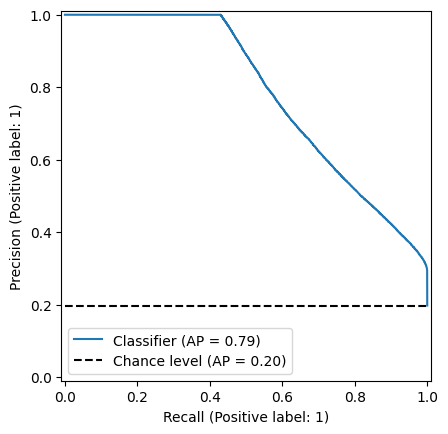

In [128]:
# Finding best threshold for the ensemble model
ensemble_best_threshold = pick_best_threshold(ensemble_model, X=X, y=y, run_name="Ensemble_threshold_search")

## Insights
From the threshold search using Precision-Recall curve
* Logistic regression:
    * Best threshold: 0.6515
    * Though this threshold maximizes F1-score (0.66), it comes at the cost of Recall (0.6132)
* Xgboost:
    * Best threshold: 0.6433
    * Similar pattern of lower Recall (0.629) is observed to maximize F1-score (0.6614)
* Ensemble (Best Xgboost model + Best Logreg model):
    * Best threshold: 0.6088
    * This threshold improves the F1-score (0.665) compared to individual model scores, but with significant increase in Recall (0.6585) & decrease in Precision (0.6722). It also improved the PR-AUC (Average Precision) (0.79)

# Model evaluation

Finally, we'll compare each of the above model's performances on the test set!!! 

This Test set has not been touched & set aside after the initial split in Step-0, which would give an unbiased result of the model performances.

In [15]:
# Fetch X & y for train set
X_train, y_train = train_df_copy[independent_feat], train_df_copy[target_feat]
y_train = y_train.map({"Charged Off": 1, "Fully Paid": 0})

# Drop the missing values
nan_rows = X_train.isna().any(axis=1)
X_train, y_train = X_train.loc[~nan_rows], y_train.loc[~nan_rows]
print(X_train.shape, y_train.shape)

(272745, 24) (272745,)


In [16]:
# Load the test-set
test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)
test_df.reset_index(drop=True, inplace=True)

# Fetch X & y for test set
X_test, y_test = test_df[independent_feat], test_df[target_feat]
y_test = y_test.map({"Charged Off": 1, "Fully Paid": 0})

# Drop the missing values
nan_rows = X_test.isna().any(axis=1)
X_test, y_test = X_test.loc[~nan_rows], y_test.loc[~nan_rows]
print(X_test.shape, y_test.shape)

(68030, 24) (68030,)


In [17]:
def test_set_evaluation(model, X, y, prob_thresh, run_name):
    with mlflow.start_run(run_name=run_name):
        y_probs = model.predict_proba(X)[:, 1] # probabilities for only class=1
        y_preds = y_probs >= prob_thresh # class label predictions

        # Metrics
        test_precision = precision_score(y_true=y, y_pred=y_preds)
        test_recall = recall_score(y_true=y, y_pred=y_preds)
        test_f1 = f1_score(y_true=y, y_pred=y_preds)
        test_average_precision = average_precision_score(y_true=y, y_score=y_probs)
        cls_report = classification_report(y_true=y, y_pred=y_preds, output_dict=True)
        test_cls_report = pd.DataFrame(cls_report)
        pr_curve = PrecisionRecallDisplay.from_predictions(
            y_true=y, 
            y_pred=y_probs,
            plot_chance_level=True
        )

        # Print the metrics
        print(f"Test precision: {round(test_precision, 3)}")
        print(f"Test recall: {round(test_recall, 3)}")
        print(f"Test F1: {round(test_f1, 3)}")
        print(f"Test Average Precision: {round(test_average_precision, 3)}")
        print(f"Test Classification report:\n {test_cls_report}")


        # Logging
        mlflow.log_param("Probability threshold", prob_thresh)
        mlflow.log_metrics(
            {
                "test_precision": test_precision,
                "test_recall": test_recall,
                "test_f1": test_f1,
                "test_average_precision": test_average_precision
            }
        )
        mlflow.log_table(test_cls_report.reset_index().rename(columns={"index": "Metric"}), f"{run_name.split("_")[0]}_classification_report.json")
        mlflow.log_figure(pr_curve.figure_, f"{run_name.split("_")[0]}_PR_curve.png")
        mlflow.sklearn.log_model(
            sk_model=model,
            name=f"{run_name.split("_")[0]}_eval_model",
            input_example=X.head()
        )

## Logistic regression

Test precision: 0.707
Test recall: 0.613
Test F1: 0.657
Test Average Precision: 0.778
Test Classification report:
                       0             1  accuracy     macro avg  weighted avg
precision      0.908235      0.706647   0.87382      0.807441      0.868575
recall         0.937653      0.613195   0.87382      0.775424      0.873820
f1-score       0.922710      0.656613   0.87382      0.789661      0.870359
support    54646.000000  13384.000000   0.87382  68030.000000  68030.000000


2025/12/20 13:54:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


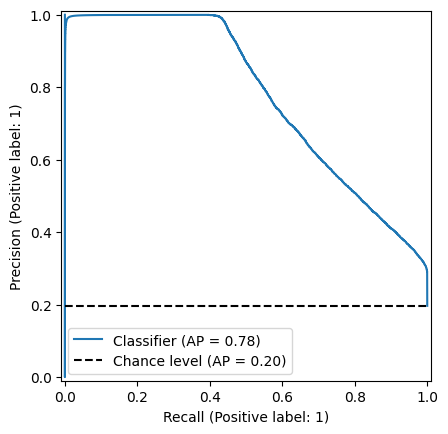

In [18]:
warnings.filterwarnings(action="ignore", category=UserWarning)

# Fit the pipeline on training set
lr_pipeline.fit(X_train, y_train)

# Evaluate on the test-set
test_set_evaluation(lr_pipeline, X_test, y_test, prob_thresh=0.6515, run_name="Logreg_test_evaluation")

## Xgboost

Test precision: 0.688
Test recall: 0.634
Test F1: 0.66
Test Average Precision: 0.78
Test Classification report:
                       0             1  accuracy     macro avg  weighted avg
precision      0.912026      0.687966   0.87141      0.799996      0.867945
recall         0.929583      0.633891   0.87141      0.781737      0.871410
f1-score       0.920721      0.659823   0.87141      0.790272      0.869392
support    54646.000000  13384.000000   0.87141  68030.000000  68030.000000


2025/12/20 13:56:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


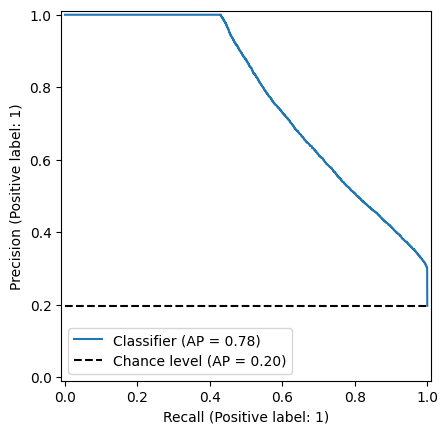

In [19]:
# Fit the pipeline on training set
xgb_pipeline.fit(X_train, y_train)

# Evaluate on the test-set
test_set_evaluation(xgb_pipeline, X_test, y_test, prob_thresh=0.6432, run_name="Xgboost_test_evaluation")

## Ensemble model

Test precision: 0.664
Test recall: 0.663
Test F1: 0.663
Test Average Precision: 0.784
Test Classification report:
                       0             1  accuracy     macro avg  weighted avg
precision      0.917455      0.663625  0.867573      0.790540      0.867517
recall         0.917707      0.662881  0.867573      0.790294      0.867573
f1-score       0.917581      0.663253  0.867573      0.790417      0.867545
support    54646.000000  13384.000000  0.867573  68030.000000  68030.000000


2025/12/20 13:56:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


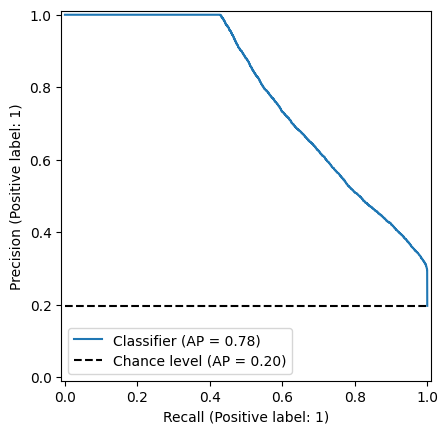

In [20]:
# Fit the pipeline on training set
ensemble_model.fit(X_train, y_train)

# Evaluate on the test-set
test_set_evaluation(ensemble_model, X_test, y_test, prob_thresh=0.6088, run_name="Ensemble_test_evaluation")

# Final Verdict

Following are the collated results on test sets for the selected models:

| Model | Precision | Recall | F1-score | PR-AUC (Average Precision) |
|:---------:|:--------:|:---------:|:---------:|:---------:|
|  Logistic regression   |  0.707   |  0.613   |  0.657   |  0.778   |
|  Xgboost   |  0.688   |  0.634   |  0.66   |  0.78   |
|  Ensemble (Logreg + Xgboost)   |  0.664   |  0.663   |  0.663   |  0.784   |

Ensemble model provides better performance in terms of Recall, F1-score & PR-AUC than the other models. Hence, we'll deploy Ensemble model to make predictions during inference time. 

Though, one disadvantage of using Ensemble model can be that since its a combination of 2 models and requires separate preprocessing for both the models, it might lead to higher latency than if we go with the next best model i.e. Xgboost which is also almost at par performance-wise and will have lower latency.